**Proyecto: Detección de Tumores Cerebrales**
*   Desarrollado por: Fredy Silva O.
*   Descripción: Este script realiza el preprocesamiento avanzado de un conjunto de datos de MRI de cerebros, con el objetivo de detectar tumores cerebrales. Se implementan transformaciones personalizadas, incluyendo
el recorte automático de la región cerebral y la aplicación de técnicas de aumento de datos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import cv2
import imutils
import torch
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Montar Google Drive (si se ejecuta en Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Definir rutas y configuraciones
ROOT = "/content/drive/MyDrive/XXX/brain_tumor_dataset"
categories = ["no", "yes"]  # 'no' para cerebros sin tumor, 'yes' para cerebros con tumor
IMG_ENDINGS = (".jpg", "jpeg", "JPG", "JPEG", "png", "PNG")

In [4]:
# Clase personalizada para recortar la región cerebral mediante puntos extremos
class CropExtremePoints:
    def __init__(self, add_pixels_value=0):
        """
        Inicializa la clase CropExtremePoints.

        Args:
            add_pixels_value (int): Número de píxeles adicionales para expandir el recorte.
        """
        self.add_pixels_value = add_pixels_value

    def __call__(self, img) -> torch.tensor:
        """
        Realiza el recorte automático de la región cerebral.

        Args:
            img (PIL Image, ndarray o torch.Tensor): Imagen de entrada.

        Returns:
            torch.Tensor: Imagen recortada.
        """
        # Convertir imagen PIL a array de numpy
        if isinstance(img, Image.Image):
            img = np.array(img)

        # Convertir tensor a array de numpy
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()

        if isinstance(img, np.ndarray) and img.ndim == 3:
            # Asegurar que la imagen tenga 3 canales (RGB)
            if img.shape[2] != 3:
                raise ValueError("La imagen debe tener 3 canales (RGB).")

            # Convertir a escala de grises y aplicar desenfoque
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            gray = cv2.GaussianBlur(gray, (5, 5), 0)

            # Aplicar umbral y eliminar ruido
            thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.erode(thresh, None, iterations=2)
            thresh = cv2.dilate(thresh, None, iterations=2)

            # Encontrar contornos
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            if not cnts:
                raise ValueError("No se encontraron contornos en la imagen.")

            # Obtener el contorno más grande
            c = max(cnts, key=cv2.contourArea)

            # Encontrar los puntos extremos
            extLeft  = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop   = tuple(c[c[:, :, 1].argmin()][0])
            extBot   = tuple(c[c[:, :, 1].argmax()][0])

            # Aplicar recorte
            ADD_PIXELS = self.add_pixels_value
            cropped_img = img[
                max(0, extTop[1] - ADD_PIXELS):min(img.shape[0], extBot[1] + ADD_PIXELS),
                max(0, extLeft[0] - ADD_PIXELS):min(img.shape[1], extRight[0] + ADD_PIXELS)
            ]

            # Convertir imagen recortada a tensor
            cropped_img = torch.from_numpy(cropped_img).permute(2, 0, 1)
            return cropped_img
        else:
            raise ValueError("La imagen de entrada debe ser un array 3D o un tensor con 3 canales.")

In [5]:
# Definir transformaciones de aumento de datos
transformations = transforms.Compose([
    CropExtremePoints(add_pixels_value=0),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=6,
                            translate=(12/224, 12/224),
                            scale=(0.75, 1.25),
                            shear=(2, 7, 3, 8)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.05, 0.225)),
    transforms.ColorJitter(brightness=(0.7, 1.5)),
    transforms.RandomRotation(6)
])

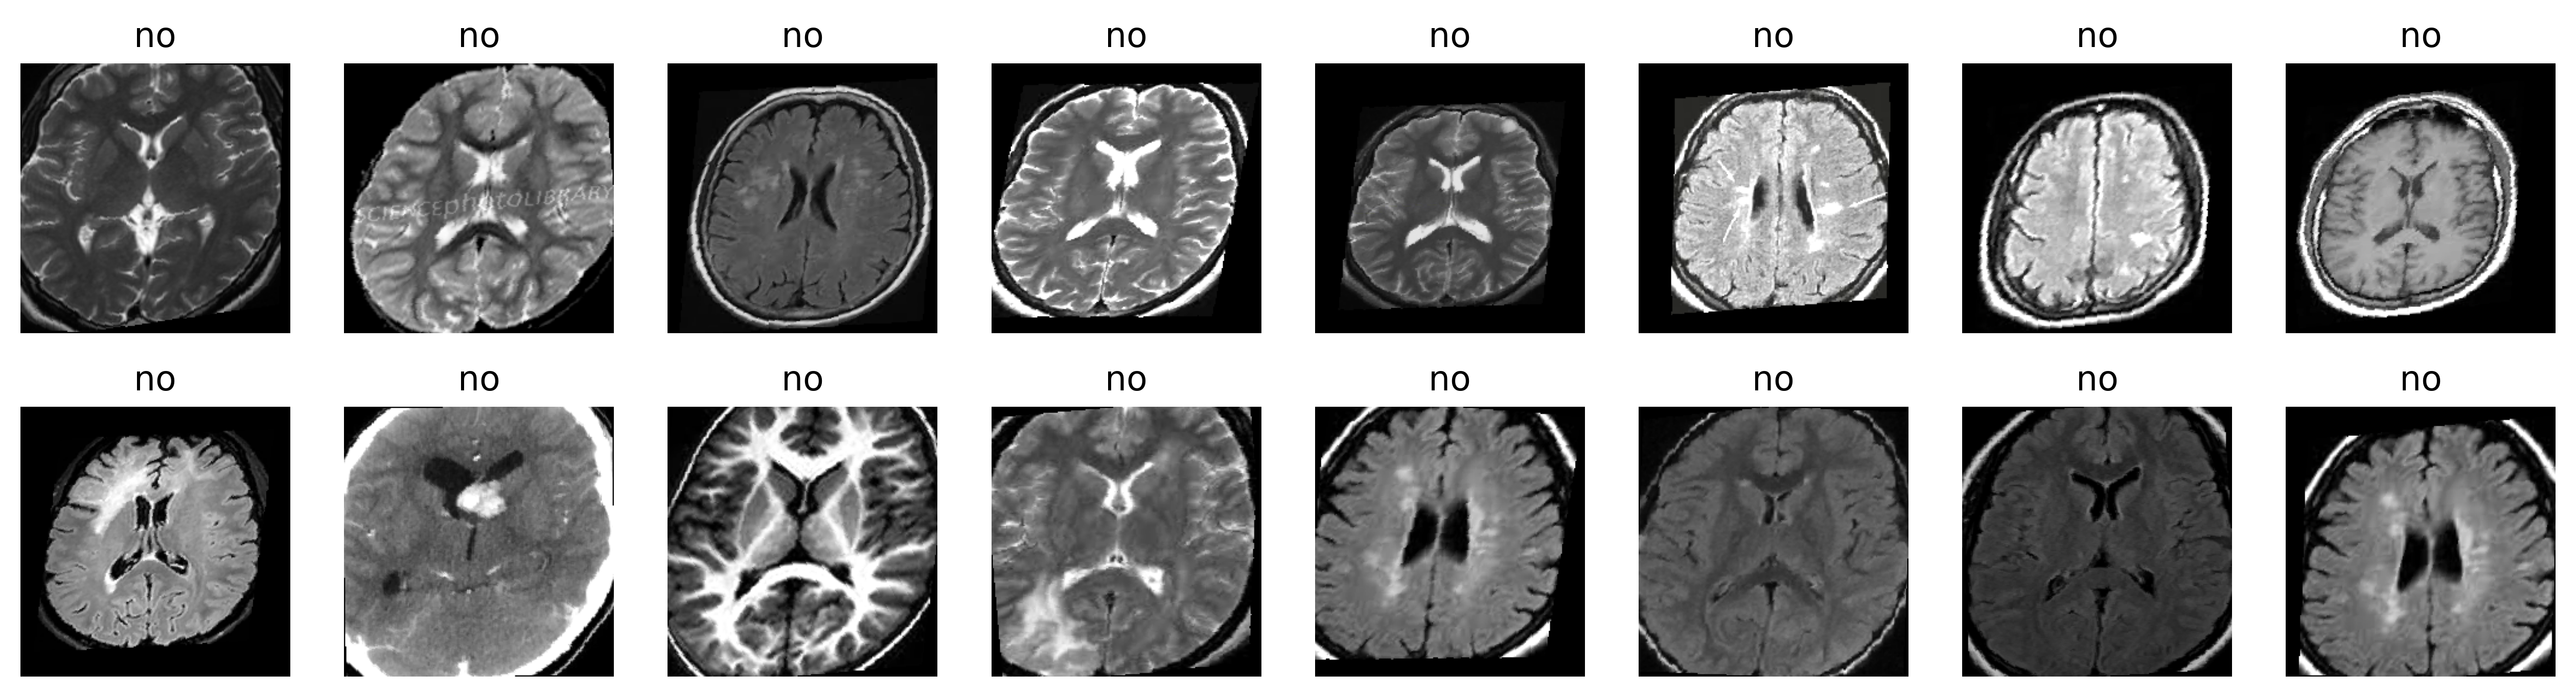

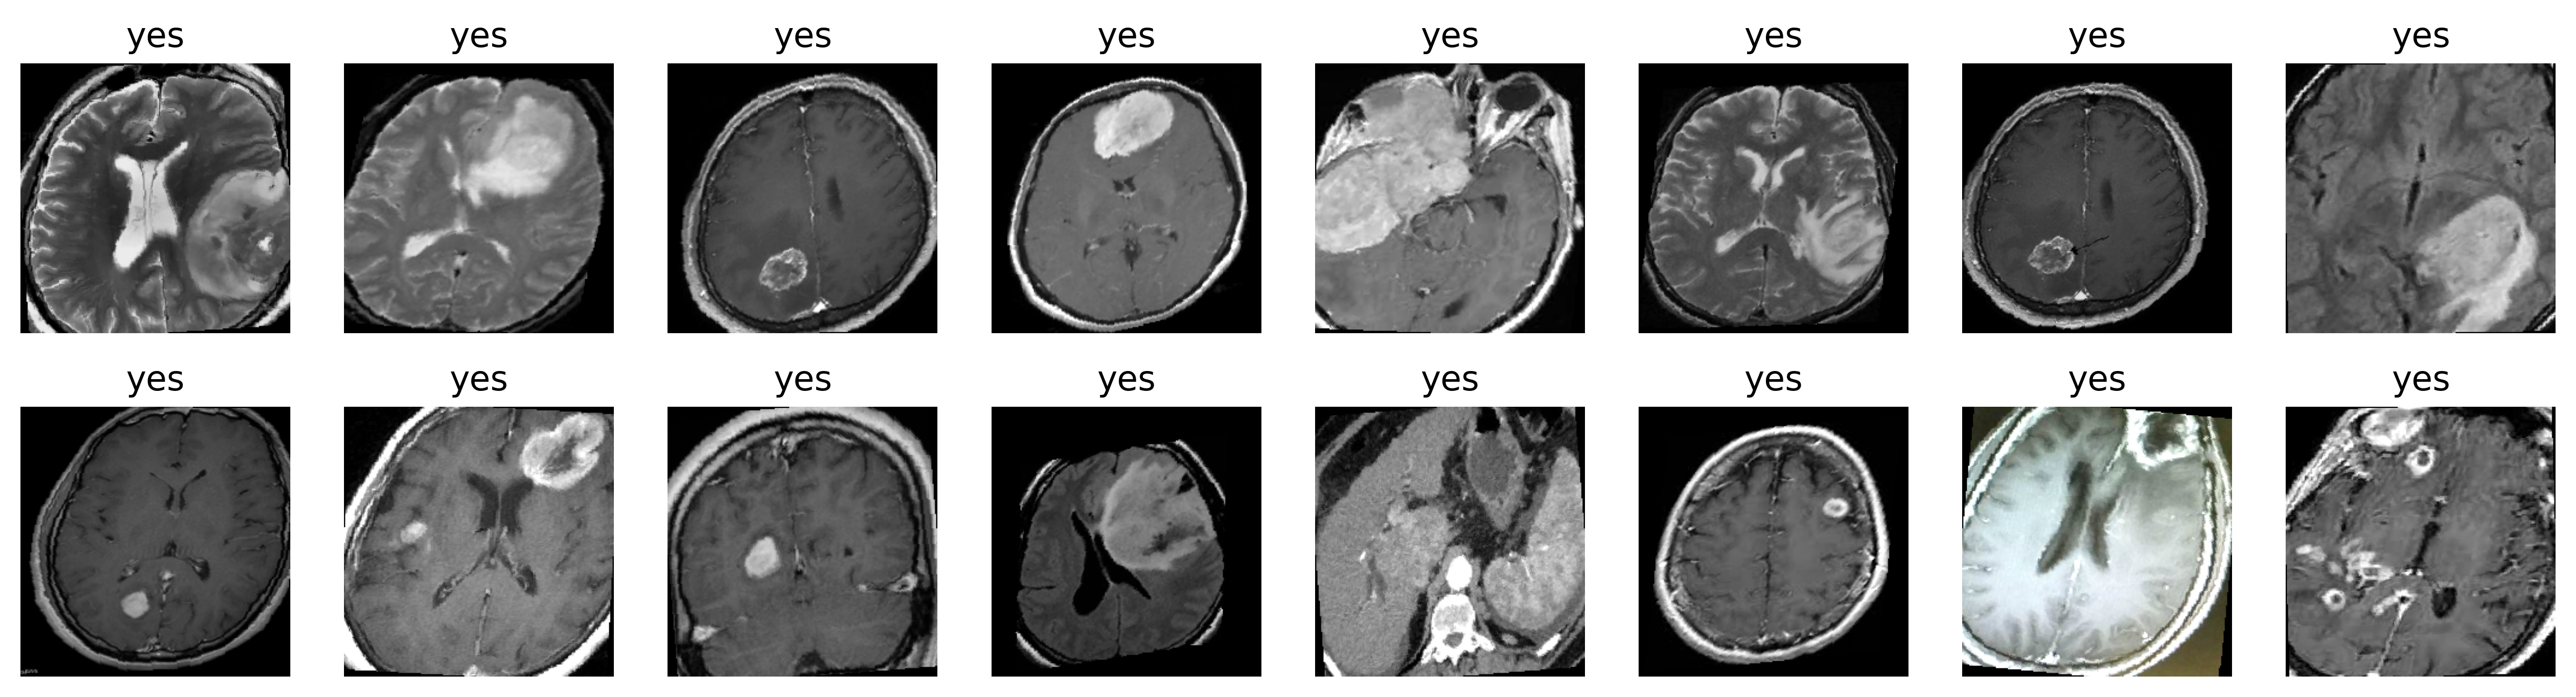

In [6]:
# Visualizar algunas de las transformaciones aplicadas
for category in categories:
    category_path = os.path.join(ROOT, category)
    img_names = random.sample(os.listdir(category_path), 16)
    img_paths = [os.path.join(category_path, img_name) for img_name in img_names]

    plt.figure(figsize=(16, 4), dpi=400)
    for k, img_path in enumerate(img_paths):
        plt.subplot(2, 8, k + 1)
        img = Image.open(img_path).convert("RGB")
        img = transformations(img)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)
    plt.show()